<a href="https://colab.research.google.com/github/arutraj/ML_Basics/blob/main/13_14_Image_Augmentation_on_Emergency_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# %tensorflow_version 1.x

# Steps to solve Emergency vs Non-Emergency vehicle classification problem using Image Augmentation

<ol>1. Loading and pre-processing the dataset</ol>
<ol>2. Creating training and validation set</ol>
<ol>3. Augmenting Images</ol>
<ol>4. Defining the model architecture</ol>
<ol>5. Training the model</ol>
<ol>6. Evaluating model performance</ol>

## 1. Loading and pre-processing the dataset

In [2]:
# importing the libraries
import pandas as pd
import numpy as np
from skimage.io import imread
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# libraries for performing image augmentation tasks
from skimage.transform import rotate
from skimage.util import random_noise
from skimage.filters import gaussian
from skimage.transform import AffineTransform, warp

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!ls /content/drive/MyDrive/AnalyticsVidya/DeepLearning/images/*jpg |wc -l

2352


In [4]:
# reading the csv file
data = pd.read_csv('/content/emergency_classification.csv')

In [5]:
# create random number generator
seed = 42

In [7]:
# load images and store it in numpy array

# empty list to store the images
X = []
# iterating over each image
for img_name in data.image_names:
    # loading the image using its name
    img = plt.imread('/content/drive/MyDrive/AnalyticsVidya/DeepLearning/images/' + img_name)
    # normalizing the pixel values
    img = img/255
    # saving each image in the list
    X.append(img)

# converting the list of images into array
X=np.array(X)

# storing the target variable in separate variable
y = data.emergency_or_not.values

In [8]:
# shape of original dataset
X.shape, y.shape

((2352, 224, 224, 3), (2352,))

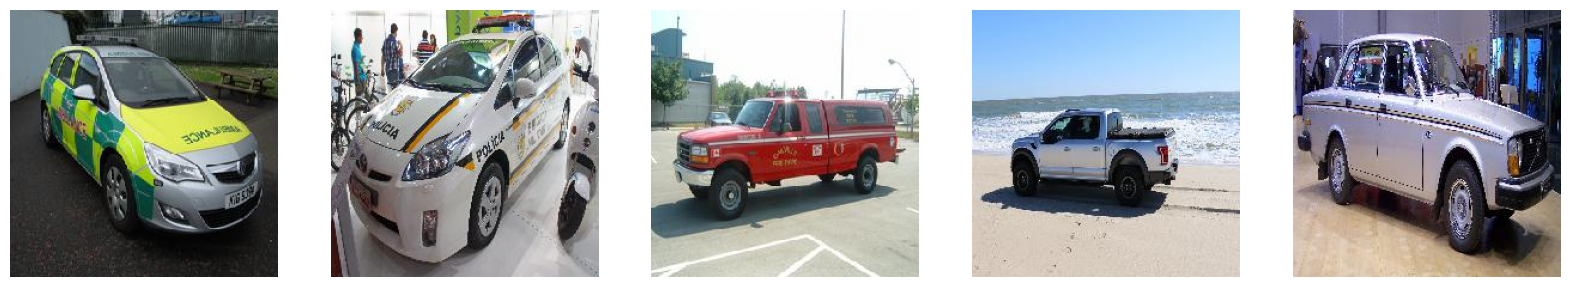

In [10]:
# visualizing images
fig,ax = plt.subplots(nrows=1,ncols=5,figsize=(20,20))
for i in range(5):
    ax[i].imshow(X[i*400])
    ax[i].axis('off')

## 2. Creating training and validation set

In [11]:
# creating a training and validation set
X_train, X_valid, y_train, y_valid=train_test_split(X,y,test_size=0.3, random_state=seed)

In [12]:
# shape of training and validation set
(X_train.shape, y_train.shape), (X_valid.shape, y_valid.shape)

(((1646, 224, 224, 3), (1646,)), ((706, 224, 224, 3), (706,)))

## 3. Augmenting Images

In [24]:
# augmenting the training images
final_train_data = []
final_target_train = []
for i in tqdm(range(X_train.shape[0])):
    # original image
    final_train_data.append(X_train[i])
    # image rotation
    final_train_data.append(rotate(X_train[i], angle=30, mode = 'edge'))
    # image flipping (left-to-right)
    final_train_data.append(np.fliplr(X_train[i]))
    # image flipping (up-down)
    final_train_data.append(np.flipud(X_train[i]))
    # image noising
    final_train_data.append(random_noise(X_train[i],var=0.2))
    for j in range(5):
        final_target_train.append(y_train[i])

100%|██████████| 1646/1646 [00:13<00:00, 123.41it/s]


In [25]:
# converting images and target to array
final_train = np.array(final_train_data)
final_target_train = np.array(final_target_train)

In [26]:
# shape of new training set
final_train.shape, final_target_train.shape

((8230, 224, 224, 3), (8230,))

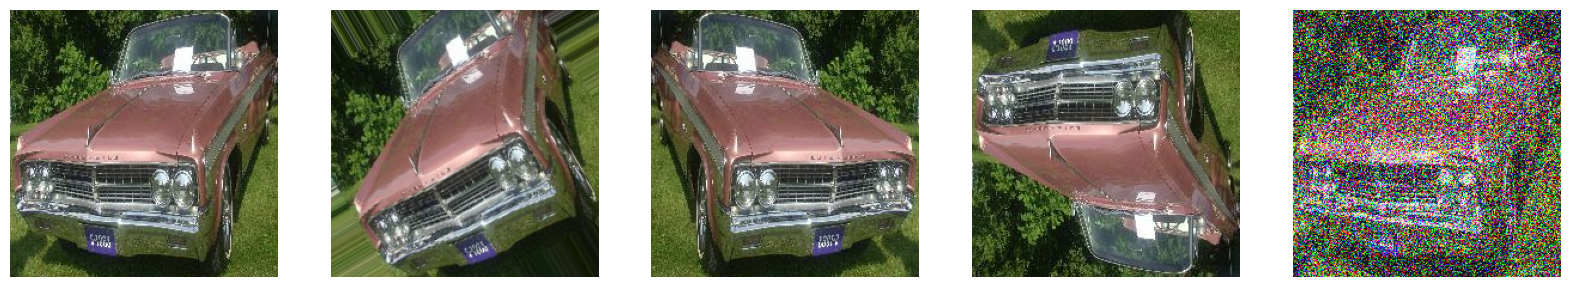

In [27]:
# visualizing the augmented images
fig,ax = plt.subplots(nrows=1,ncols=5,figsize=(20,20))
for i in range(5):
    ax[i].imshow(final_train[i+45])
    ax[i].axis('off')

In [28]:
# converting 3 dimensional image to 1 dimensional image
final_train = final_train.reshape(final_train.shape[0], 224*224*3)
final_train.shape

(8230, 150528)

In [29]:
# minimum and maximum pixel values of training images
final_train.min(), final_train.max()

(0.0, 1.0)

In [30]:
# converting 3 dimensional validation image to 1 dimensional image
final_valid = X_valid.reshape(X_valid.shape[0], 224*224*3)
final_valid.shape

(706, 150528)

In [31]:
# minimum and maximum pixel values of validation images
final_valid.min(), final_valid.max()

(0.0, 1.0)

## 4. Defining the model architecture

In [32]:
# importing functions from keras to define the neural network architecture
from keras.layers import Dense, InputLayer, Dropout, BatchNormalization
from keras.models import Sequential
# importing adam optimizer from keras optimizer module
from keras.optimizers import Adam

In [34]:
# defining the adam optimizer and setting the learning rate as 10^-5
adam = Adam(learning_rate=1e-5)

In [35]:
# defining and compiling the model architecture
model=Sequential()

model.add(InputLayer(input_shape=(224*224*3,)))
model.add(Dense(100, activation='sigmoid'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.5))
model.add(Dense(100, activation='sigmoid'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.5))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

In [36]:
# summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               15052900  
                                                                 
 batch_normalization (Batch  (None, 100)               400       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 batch_normalization_1 (Bat  (None, 100)               400       
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 100)               0

## 5. Training the model

In [37]:
# training the model
model_history = model.fit(final_train, final_target_train, epochs=50, batch_size=128,validation_data=(final_valid,y_valid))

Epoch 1/50
65/65 [==============================] - 8s 58ms/step - loss: 0.8813 - accuracy: 0.5899 - val_loss: 0.7000 - val_accuracy: 0.4405
Epoch 2/50
65/65 [==============================] - 2s 37ms/step - loss: 0.7699 - accuracy: 0.6367 - val_loss: 0.6635 - val_accuracy: 0.5892
Epoch 3/50
65/65 [==============================] - 2s 37ms/step - loss: 0.7308 - accuracy: 0.6604 - val_loss: 0.6292 - val_accuracy: 0.6686
Epoch 4/50
65/65 [==============================] - 2s 37ms/step - loss: 0.6830 - accuracy: 0.6852 - val_loss: 0.5863 - val_accuracy: 0.6941
Epoch 5/50
65/65 [==============================] - 2s 37ms/step - loss: 0.6559 - accuracy: 0.6964 - val_loss: 0.5612 - val_accuracy: 0.7210
Epoch 6/50
65/65 [==============================] - 2s 37ms/step - loss: 0.6146 - accuracy: 0.7187 - val_loss: 0.5622 - val_accuracy: 0.7054
Epoch 7/50
65/65 [==============================] - 2s 37ms/step - loss: 0.6015 - accuracy: 0.7262 - val_loss: 0.5759 - val_accuracy: 0.7068
Epoch 8/50
65

## 6. Evaluating model performance

In [38]:
y_pred

NameError: name 'y_pred' is not defined

In [39]:
# accuracy on validation set
print('Accuracy on validation set:', accuracy_score(y_valid, np.where(model.predict(final_valid)[:, 0]<0.5, 0, 1)))

23/23 [==============================] - 0s 9ms/step
Accuracy on validation set: 0.6997167138810199


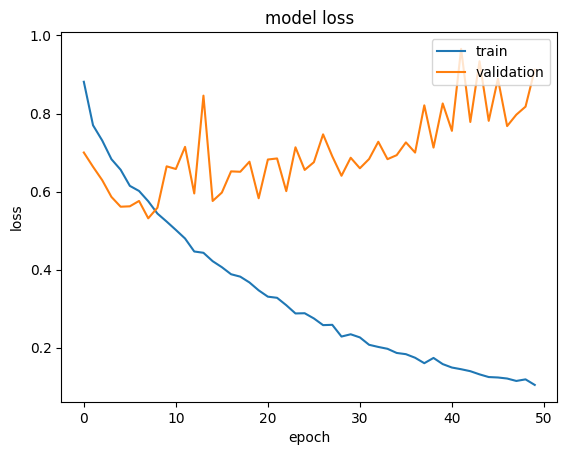

In [40]:
# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

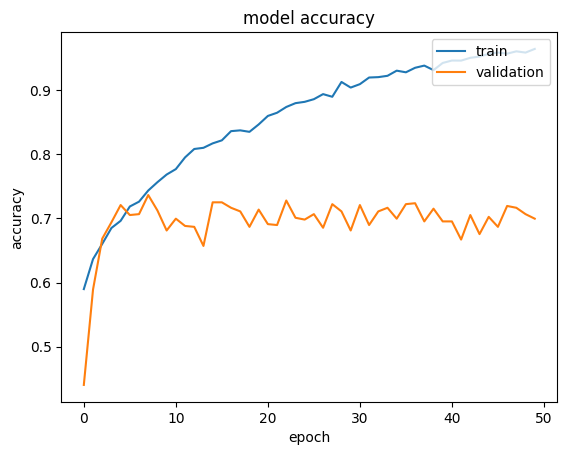

In [41]:
# summarize history for accuracy
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()